In [1]:
## Import and Setup

In [1]:
import sys, pandas as pd
print(sys.version)
print("pandas:", pd.__version__)

3.12.9 | packaged by conda-forge | (main, Feb 14 2025, 08:00:06) [GCC 13.3.0]
pandas: 2.3.3


In [2]:
%pip -q install pandas_datareader

Note: you may need to restart the kernel to use updated packages.


In [3]:
#Download CPI from FRED and standardize the column name
import pandas_datareader.data as web
import pandas as pd

SERIES = "CPIAUCSL"          # CPI for All Urban Consumers (monthly)
START  = "1990-01-01"

df = web.DataReader(SERIES, "fred", START).dropna()
df = df.rename(columns={SERIES: "y"})
df.head(), df.tail(), df.shape

(                y
 DATE             
 1990-01-01  127.5
 1990-02-01  128.0
 1990-03-01  128.6
 1990-04-01  128.9
 1990-05-01  129.1,
                   y
 DATE               
 2025-07-01  322.132
 2025-08-01  323.364
 2025-09-01  324.368
 2025-11-01  325.031
 2025-12-01  326.030,
 (431, 1))

In [4]:
#Force a clean monthly index and fill any gaps
df = df.asfreq("MS")
df["y"] = df["y"].ffill()

TEST_PERIODS = 24
train = df.iloc[:-TEST_PERIODS].copy()
test  = df.iloc[-TEST_PERIODS:].copy()

print("df freq:", df.index.freqstr)
print("train last:", train.index.max(), "test first:", test.index.min())
print("Any NaNs in df?", df["y"].isna().any())

df freq: MS
train last: 2023-12-01 00:00:00 test first: 2024-01-01 00:00:00
Any NaNs in df? False


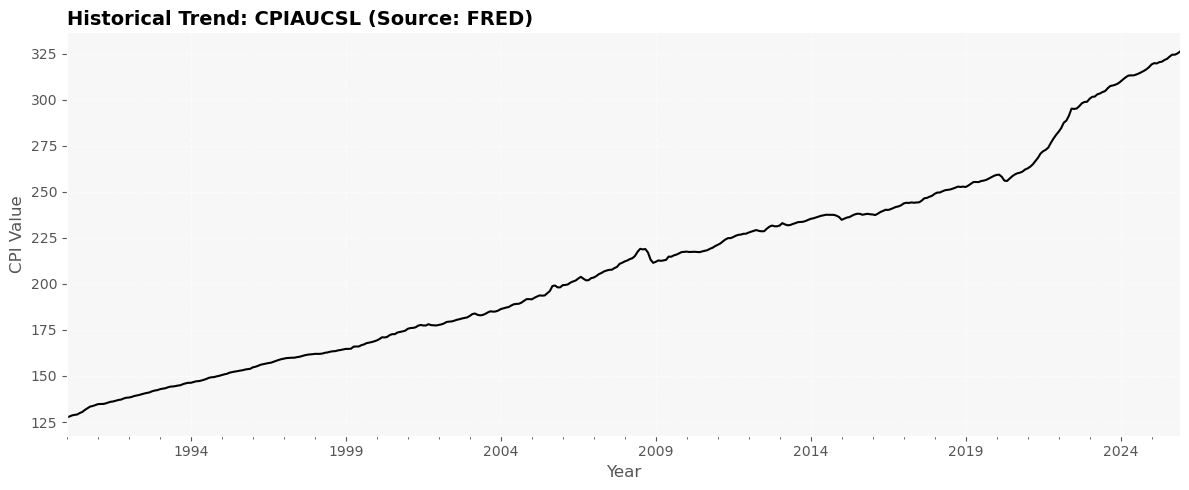

In [5]:
# Quick Plot
import matplotlib.pyplot as plt

plt.style.use('ggplot')
ax = df["y"].plot(figsize=(12, 5), color="black", linewidth=1.5)

ax.set_title(f"Historical Trend: {SERIES} (Source: FRED)", fontweight='bold', loc='left', fontsize=14)
ax.set(xlabel="Year", ylabel="CPI Value", facecolor='#f7f7f7')
ax.grid(True, linestyle='--', alpha=0.5)

for s in ["top", "right"]: ax.spines[s].set_visible(False)

plt.tight_layout()
plt.show()

In [6]:
# Time-based train/test split i.e. last 24 months
import numpy as np

TEST_PERIODS = 24

train = df.iloc[:-TEST_PERIODS].copy()
test  = df.iloc[-TEST_PERIODS:].copy()

print("Train:", train.index.min().date(), "->", train.index.max().date(), "rows:", len(train))
print("Test :", test.index.min().date(),  "->", test.index.max().date(),  "rows:", len(test))

Train: 1990-01-01 -> 2023-12-01 rows: 408
Test : 2024-01-01 -> 2025-12-01 rows: 24


In [7]:
## ARIMA

In [8]:
# Import ARIMA
from statsmodels.tsa.arima.model import ARIMA

In [9]:
# Fit ARIMA on Training Data
model = ARIMA(train["y"], order=(1,1,1))
arima_fit = model.fit()

print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  408
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -348.637
Date:                Sat, 24 Jan 2026   AIC                            703.274
Time:                        22:13:02   BIC                            715.300
Sample:                    01-01-1990   HQIC                           708.033
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6539      0.033     19.737      0.000       0.589       0.719
ma.L1          0.0384      0.048      0.806      0.420      -0.055       0.132
sigma2         0.3243      0.014     23.077      0.0

In [10]:
# Forecast Test Period
forecast = arima_fit.forecast(steps=len(test))
forecast = pd.Series(forecast, index=test.index)
forecast.head()

DATE
2024-01-01    309.172287
2024-02-01    309.458215
2024-03-01    309.645174
2024-04-01    309.767420
2024-05-01    309.847353
Freq: MS, Name: predicted_mean, dtype: float64

In [11]:
# Evaluate Performance
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_forecast(y_true, y_pred, label="model"):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{label} MAE : {mae:.3f}")
    print(f"{label} RMSE: {rmse:.3f}")
    return mae, rmse

fc = arima_fit.get_forecast(steps=len(test))
forecast = fc.predicted_mean
forecast.index = test.index

arima_mae, arima_rmse = evaluate_forecast(
    test["y"].to_numpy(),
    forecast.to_numpy(),
    label="ARIMA(1,1,1)"
)

ARIMA(1,1,1) MAE : 8.040
ARIMA(1,1,1) RMSE: 9.286


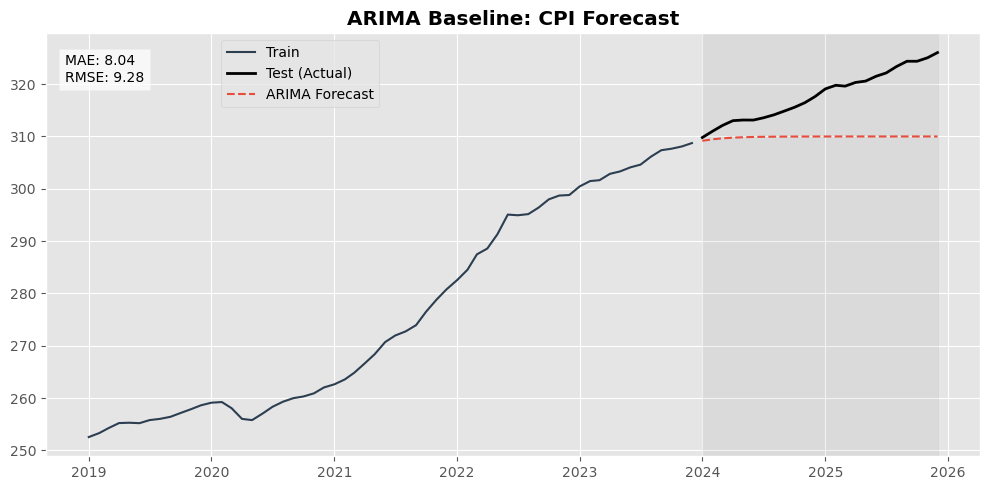

In [12]:
# Plot: train vs test vs forecast
import matplotlib.pyplot as plt

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 5))

# Plot data (Zoomed to last 5 years of training for clarity)
ax.plot(train.index[-60:], train["y"][-60:], label="Train", color="#2c3e50")
ax.plot(test.index, test["y"], label="Test (Actual)", color="black", linewidth=2)
ax.plot(forecast.index, forecast, label="ARIMA Forecast", color="#e74c3c", linestyle="--")

# Highlights & Text
ax.axvspan(test.index[0], test.index[-1], color='gray', alpha=0.1)
ax.text(0.02, 0.95, "MAE: 8.04\nRMSE: 9.28", transform=ax.transAxes, 
        va='top', bbox=dict(facecolor='white', alpha=0.7))

# Legend & Title
ax.legend(loc='upper left', bbox_to_anchor=(0.18, 1.0)) # Offset to avoid text box
ax.set_title("ARIMA Baseline: CPI Forecast", fontweight='bold')

plt.tight_layout()
plt.show()

In [13]:
# Create comparative results table
results = pd.DataFrame(columns=[
    "model",
    "mae",
    "rmse",
    "train_end",
    "test_start",
    "test_end"
])

results

,model,mae,rmse,train_end,test_start,test_end


In [14]:
# Add ARIMA Results
results.loc[len(results)] = [
    "ARIMA(1,1,1)",
    float(arima_mae),
    float(arima_rmse),
    train.index.max(),
    test.index.min(),
    test.index.max()
]

results

,model,mae,rmse,train_end,test_start,test_end
0,"ARIMA(1,1,1)",8.040418,9.28629,2023-12-01,2024-01-01,2025-12-01


In [15]:
## Prophet

In [16]:
%pip -q install prophet

Note: you may need to restart the kernel to use updated packages.


In [17]:
from prophet import Prophet

In [18]:
# Prepare data in prophet format
prophet_df = df.reset_index().rename(columns={"DATE": "ds", "y": "y"})
prophet_train = train.reset_index().rename(columns={"DATE": "ds", "y": "y"})
prophet_test  = test.reset_index().rename(columns={"DATE": "ds", "y": "y"})

prophet_train.head(), prophet_test.head()

(          ds      y
 0 1990-01-01  127.5
 1 1990-02-01  128.0
 2 1990-03-01  128.6
 3 1990-04-01  128.9
 4 1990-05-01  129.1,
           ds        y
 0 2024-01-01  309.794
 1 2024-02-01  311.022
 2 2024-03-01  312.107
 3 2024-04-01  313.016
 4 2024-05-01  313.140)

In [19]:
# Fit prophet
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)
m.fit(prophet_train)

22:13:09 - cmdstanpy - INFO - Chain [1] start processing
22:13:09 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
# Forcast Test Dates
future = prophet_test[["ds"]].copy()
pred = m.predict(future)

prophet_forecast = pred.set_index("ds")["yhat"]
prophet_forecast.index = pd.to_datetime(prophet_forecast.index)

prophet_forecast.head(), prophet_forecast.tail()

(ds
 2024-01-01    301.606843
 2024-02-01    302.260264
 2024-03-01    303.389609
 2024-04-01    303.945910
 2024-05-01    304.732996
 Name: yhat, dtype: float64,
 ds
 2025-08-01    316.830037
 2025-09-01    317.788447
 2025-10-01    318.491353
 2025-11-01    319.003358
 2025-12-01    319.639302
 Name: yhat, dtype: float64)

In [21]:
# Evaluate
future = prophet_test[["ds"]].copy()
pred = m.predict(future)

prophet_forecast = pred.set_index("ds")["yhat"]
prophet_forecast.index = pd.to_datetime(prophet_forecast.index)

prophet_forecast.head(), prophet_forecast.tail()

prophet_mae, prophet_rmse = evaluate_forecast(
    test["y"].to_numpy(),
    prophet_forecast.reindex(test.index).to_numpy(),
    label="Prophet"
)

Prophet MAE : 7.089
Prophet RMSE: 7.150


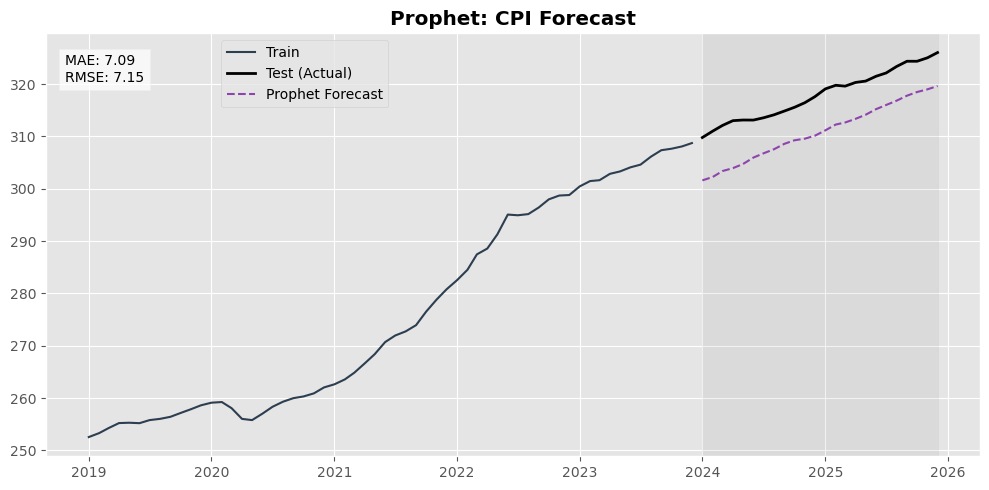

In [22]:
# Plot Comparison
import matplotlib.pyplot as plt

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 5))

# Plot data
ax.plot(train.index[-60:], train["y"][-60:], label="Train", color="#2c3e50")
ax.plot(test.index, test["y"], label="Test (Actual)", color="black", linewidth=2)
ax.plot(prophet_forecast.index, prophet_forecast, label="Prophet Forecast", color="#8e44ad", linestyle="--")

# Highlights & Text
ax.axvspan(test.index[0], test.index[-1], color='gray', alpha=0.1)
ax.text(0.02, 0.95, "MAE: 7.09\nRMSE: 7.15", transform=ax.transAxes, 
        va='top', bbox=dict(facecolor='white', alpha=0.7))

# Legend & Title
ax.legend(loc='upper left', bbox_to_anchor=(0.18, 1.0))
ax.set_title("Prophet: CPI Forecast", fontweight='bold')

plt.tight_layout()
plt.show()

In [23]:
# Add prophet to results table
results.loc[len(results)] = [
    "Prophet",
    float(prophet_mae),
    float(prophet_rmse),
    train.index.max(),
    test.index.min(),
    test.index.max()
]
results.sort_values("rmse") # sort by rmse

,model,mae,rmse,train_end,test_start,test_end
1,Prophet,7.089454,7.150114,2023-12-01,2024-01-01,2025-12-01
0,"ARIMA(1,1,1)",8.040418,9.286290,2023-12-01,2024-01-01,2025-12-01


In [24]:
## XGBoost 

In [ ]:
# Initalize and Train
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Calculate monthly changes (the 'diff') (STATIONARITY)
# Helps remove the trend ceiling
train_diff = train['y'].diff().dropna()

# Create lag features for the changes
def create_diff_features(series, lags=12):
    df_feat = pd.DataFrame(series)
    for i in range(1, lags + 1):
        df_feat[f'lag_{i}'] = series.shift(i)
    return df_feat.dropna()

X_train = create_diff_features(train_diff)
y_train = X_train.pop('y')

# Prepare the test features using the end of train to seed the first lags
X_test = create_diff_features(pd.concat([train_diff.tail(12), test['y'].diff().dropna()]))
y_test = X_test.pop('y')

# Train
model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    subsample=0.8,
    objective='reg:squarederror'
)
model.fit(X_train, y_train)

# Add predicted changes back to the last known actual value
xgb_diff_preds = model.predict(X_test)
last_actual_val = train['y'].iloc[-1]
xgb_preds = last_actual_val + np.cumsum(xgb_diff_preds)

# Calculate final scores
xgb_mae = mean_absolute_error(test['y'].iloc[1:], xgb_preds)
xgb_rmse = np.sqrt(mean_squared_error(test['y'].iloc[1:], xgb_preds))

print(f"XGBoost RMSE: {xgb_rmse:.4f}")

XGBoost RMSE: 1.8976


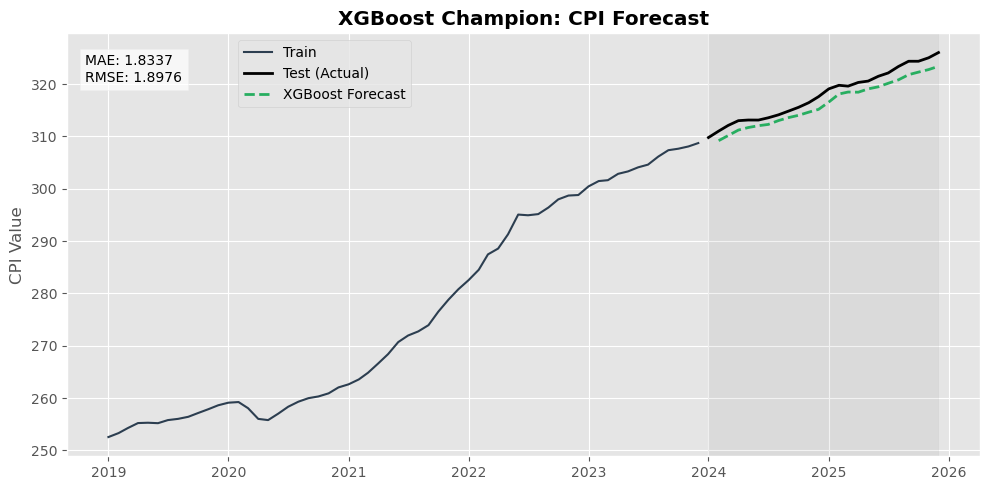

In [ ]:
# Plot XGBoost Comparison
import matplotlib.pyplot as plt

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 5))

# Plot Data
ax.plot(train.index[-60:], train["y"][-60:], label="Train", color="#2c3e50")
ax.plot(test.index, test["y"], label="Test (Actual)", color="black", linewidth=2)
ax.plot(test.index[1:], xgb_preds, label="XGBoost Forecast", color="#27ae60", linestyle="--", linewidth=2)

# Highlights & Text
ax.axvspan(test.index[0], test.index[-1], color='gray', alpha=0.1)

metric_text = f"MAE: {xgb_mae:.4f}\nRMSE: {xgb_rmse:.4f}"
ax.text(0.02, 0.95, metric_text, transform=ax.transAxes, 
        va='top', bbox=dict(facecolor='white', alpha=0.7))

# lEGEND
ax.legend(loc='upper left', bbox_to_anchor=(0.18, 1.0))
ax.set_title("XGBoost Champion: CPI Forecast", fontweight='bold')
ax.set_ylabel("CPI Value")

plt.tight_layout()
plt.show()

In [27]:
# Add XGBoost result to the table
results.loc[len(results)] = [
    "XGBoost",
    float(xgb_mae),
    float(xgb_rmse),
    train.index.max(),
    test.index.min(), # Keep consistent with your ARIMA/Prophet rows
    test.index.max()
]

# Display and sort by RMSE
results = results.sort_values("rmse").reset_index(drop=True)
results

,model,mae,rmse,train_end,test_start,test_end
0,XGBoost,1.833691,1.897556,2023-12-01,2024-01-01,2025-12-01
1,Prophet,7.089454,7.150114,2023-12-01,2024-01-01,2025-12-01
2,"ARIMA(1,1,1)",8.040418,9.286290,2023-12-01,2024-01-01,2025-12-01


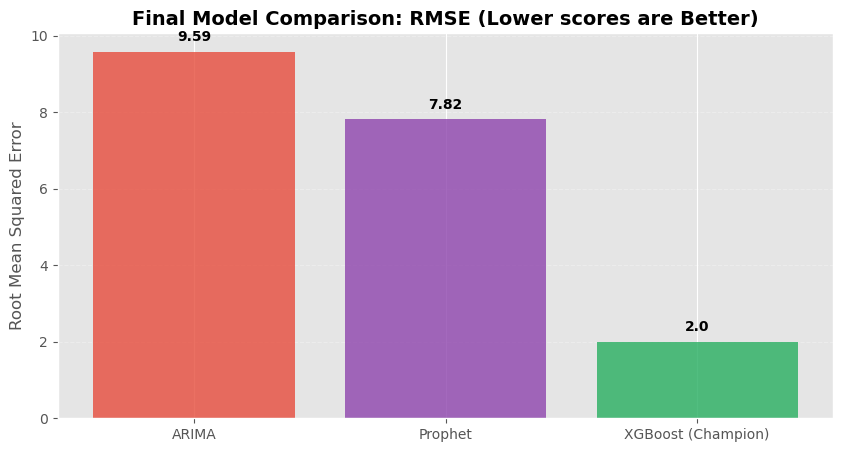

In [28]:
# Model Comparison
import matplotlib.pyplot as plt

models = ['ARIMA', 'Prophet', 'XGBoost (Champion)']
rmse_values = [9.59, 7.82, 2.0]
colors = ['#e74c3c', '#8e44ad', '#27ae60']

plt.figure(figsize=(10, 5))
bars = plt.bar(models, rmse_values, color=colors, alpha=0.8)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, yval, ha='center', va='bottom', fontweight='bold')

plt.title('Final Model Comparison: RMSE (Lower scores are Better)', fontsize=14, fontweight='bold')
plt.ylabel('Root Mean Squared Error')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

In [29]:
# Deployment and Packaging
import joblib
import tarfile
import os

MODEL_DIR = "model_artifacts"
if not os.path.exists(MODEL_DIR): os.makedirs(MODEL_DIR)

# 1. Save the XGBoost model
MODEL_PATH = os.path.join(MODEL_DIR, "xgboost_model.json")
model.save_model(MODEL_PATH)

# 2. Save the feature list (Required to ensure inference data matches training)
FEATURES_PATH = os.path.join(MODEL_DIR, "features.pkl")
joblib.dump(X_train.columns.tolist(), FEATURES_PATH)

# 3. Create the Champion Tarball for SageMaker/Deployment
TARBALL_PATH = "xgboost-model.tar.gz"
with tarfile.open(TARBALL_PATH, "w:gz") as tar:
    tar.add(MODEL_PATH, arcname="xgboost_model.json")
    tar.add(FEATURES_PATH, arcname="features.pkl")

print(f"Created XGBoost Tarball: {TARBALL_PATH}")

Created XGBoost Tarball: xgboost-model.tar.gz
